# Implementar un MLP con Backpropagation para resolver el problema de la función XOR 

<img src="figs/fig-MLP_XOR.png" width="50%">


1. **Definir la arquitectura de la red**:  
   - La red tendrá 2 entradas (los valores binarios del XOR), una capa oculta con 2 neuronas, y una neurona de salida.
   - Usar la función de activación sigmoide en las neuronas de la capa oculta y de salida.
   - Establecer una tasa de aprendizaje (ej. 0.5) y el número de épocas de entrenamiento.

   Por ejemplo, para la capa de salida (2 neuronas en la capa oculta, 1 neurona de salida):
 $$ W^{(2)} \in \mathbb{R}^{1 \times 2} $$
 $$ b^{(2)} \in \mathbb{R}^{1 \times 1} $$

2. **Inicializar los pesos y los sesgos**:  
   - Inicializar los pesos de las conexiones de la capa de entrada a la capa oculta y de la capa oculta a la capa de salida, de manera aleatoria (puedes usar la inicialización Xavier).
   - También inicializar los sesgos de cada capa.

3. **Propagación hacia adelante (Forward pass)**:  
   - Para cada entrada, multiplicar las entradas por los pesos de la capa oculta y sumar el sesgo.
   - Aplicar la función de activación (sigmoide) para obtener las activaciones de la capa oculta.
   - Repetir el proceso con los valores de la capa oculta para calcular la activación de la capa de salida.

4. **Calcular el error**:  
   - Calcular el error en la salida utilizando una función de error, como el Error Cuadrático Medio (MSE).

5. **Backpropagation (Propagación hacia atrás)**:  
   - Calcular los gradientes de error en la capa de salida
   - Propagar el error hacia la capa oculta, calculando el gradiente de error en la capa oculta.
   
6. **Actualizar los pesos y sesgos**:  
   - Usar los gradientes obtenidos para ajustar los pesos y los sesgos de la capa de salida y de la capa oculta utilizando el gradiente descendente.
   
7. **Repetir el entrenamiento**:  
   - Repetir los pasos de forward, cálculo de error y backpropagation por el número de épocas definido hasta que el error disminuya significativamente.

8. **Evaluar el modelo**:  
   - Después del entrenamiento, probar la red con las entradas XOR y verificar que las salidas estén cerca de los valores esperados (0 o 1).
   






In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# ====================================================
# Funciones para activación y  su derivada
# ====================================================
def cargar_dataset(ruta):
    """
    Carga un conjunto de datos desde un archivo CSV y separa las características (X)
    de la columna objetivo (y), que corresponde a la última columna del archivo.

    Parámetros:
    ------------
    ruta : str
        Ruta del archivo CSV (por ejemplo: './iris_train.csv')

    Retorna:
    ---------
    X : np.ndarray
        Matriz con las características o variables de entrada.
    y : np.ndarray
        Vector columna con la clase o variable objetivo.
    """
    # Cargar el archivo CSV con pandas
    datos = pd.read_csv(ruta)

    # Separar las características (todas menos la última columna)
    X = datos.iloc[:, :-1].values  

    # Separar la columna objetivo (última columna)
    y = datos.iloc[:, -1].values  

    # Asegurar que y sea un vector columna (n x 1)
    y = y.reshape(-1, 1)

    # Mostrar información del dataset cargado
    print(f"Conjunto de datos cargado desde: {ruta}")
    print(f"   → Ejemplos: {X.shape[0]}, Características: {X.shape[1]}")
    print(f"   → Clases únicas en y: {np.unique(y).ravel()}")

    return X, y


# Función de activación sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivada de la sigmoide
def sigmoid_derivative(x):
    # return sigmoid(x) * (1 - sigmoid(x))
    return x * (1 - x)

# ====================================================
# Funciones para manejo de la semilla
# ====================================================

# Establece la semilla para la generación de números aleatorios
def seed(random_state=24):
    np.random.seed(random_state)
    random.seed(random_state)

# ====================================================
# Funciones para inicialización y normalización
# ====================================================

# Inicialización Xavier
def xavier_initialization(input_size, output_size): 
    return np.random.randn(input_size, output_size) * np.sqrt(1 / input_size)
# Inicialización normal
def normal_initialization(input_size, output_size):
    return np.random.randn(input_size, output_size)
# Normalización Z-score
def zscore_normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_norm = (X - mean) / std
    return X_norm

#Función para crear minibatches
def create_minibatches(X, y, batch_size):
    """
    Genera los lotes de datos (batchs) de acuerdo al parámetro batch_size de forma aleatoria para el procesamiento. 
    """
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)  # Mezcla los índices aleatoriamente
    X_shuffled, y_shuffled = X[indices], y[indices]  # Reordena X e y según los índices aleatorios
    
    # Divide los datos en minibatches
    for X_batch, y_batch in zip(np.array_split(X_shuffled, np.ceil(n_samples / batch_size)), 
                                np.array_split(y_shuffled, np.ceil(n_samples / batch_size))):
        yield X_batch, y_batch

    
class MLP_TODO:
    def __init__(self, num_entradas, num_neuronas_ocultas, num_salidas, epochs, batch_size=128, learning_rate=0.2, normalizacion="none",inicializacion="xavier",random_state=42):

        # Establecer la semilla para la generación de números aleatorios
        seed(33)
        # Definir la tasa de aprendizaje
        self.learning_rate = learning_rate
        # Definir el número de épocas
        self.epochs = epochs
        # Definir el tamaño del batch de procesamiento
        self.batch_size = batch_size
        # Definir el tipo de normalización
        self.normalizacion = normalizacion
        # Definir el tipo de inicialización
        self.inicializacion = inicializacion
        # definir las 
        self.num_neuronas_ocultas = num_neuronas_ocultas
        self.W1 = self.inicializar_pesos(num_entradas, self.num_neuronas_ocultas) # Pesos entre capa de entrada y capa oculta
        self.b1 = np.zeros((1, self.num_neuronas_ocultas))   # Bias de la capa oculta
        self.W2 = self.inicializar_pesos(self.num_neuronas_ocultas,num_salidas)  # Pesos entre capa oculta y capa de salida
        self.b2 = np.zeros((1, num_salidas)) # Bias de la capa de salida
        # Historial de errores
        self.errores_history = []
        # Historial de accuracy
        self.accuracy_history = []

    # ====================================================
    # Funciones para forward, backward, update, predict y train
    # ====================================================

    def forward(self, X):
        #implementar el forward pass
        #----------------------------------------------
        # 1. Propagación hacia adelante (Forward pass)
        #----------------------------------------------
        # Calcular la suma ponderada Z (z_c1) para la capa oculta 
        self.X = X
        self.z_c1 = X@self.W1 + self.b1
        #Calcular la activación de la capa oculta usando la función sigmoide
        self.a_c1 = sigmoid(self.z_c1)  # Activación capa oculta
        #Calcular la suma ponderada Z (z_c2)  para la capa de salida 
        self.z_c2  = self.a_c1 @ self.W2 + self.b2
        #Calcular la activación de la capa de salida usando la función sigmoide
        y_pred = sigmoid(self.z_c2)  # Activación capa salida
        return y_pred
    

    def loss_function_MSE(self, y_pred, y):
        #----------------------------------------------
        # 2. Cálculo del error con MSE
        #----------------------------------------------
        #Calcular el error cuadrático medio (MSE)
        self.y_pred = y_pred
        self.y = y
        error = 0.5 * np.mean((y_pred - y) ** 2)
        return error
    

    def backward(self):
        #implementar el backward pass
        # calcular los gradientes para la arquitectura de la figura anterior
        #----------------------------------------------
        # 3. Propagación hacia atrás (Backward pass)
        #----------------------------------------------
        
        #----------------------------------------------
        # Gradiente de la salida
        #----------------------------------------------
        #Calcular la derivada del error con respecto a la salida y
        dE_dy_pred = (self.y_pred - self.y)  # Derivada del error respecto a la predicción con  N ejemplos
        #Calcular la derivada de la activación de la salida con respecto a z_c2 
        d_y_pred_d_zc2 = sigmoid_derivative(self.y_pred)
        #Calcular delta de la capa de salida
        delta_c2 = dE_dy_pred * d_y_pred_d_zc2  # (N, 1)

        #----------------------------------------------
        # Gradiente en la capa oculta
        #----------------------------------------------
        # calcular la derivada de las suma ponderada respecto a las activaciones de la capa 1
        d_zc2_d_a_c1 = self.W2  
        #Propagar el error hacia la capa oculta, calcular deltas de la capa 1
        delta_c1 = delta_c2 @ d_zc2_d_a_c1.T * sigmoid_derivative(self.a_c1)  

        #calcula el gradiente de la función de error respecto a los pesos de la capa 2
        self.dE_dW2 = self.a_c1.T @ delta_c2
        self.dE_db2 = np.sum(delta_c2, axis=0, keepdims=True)
        self.dE_dW1 = self.X.T @ delta_c1 
        self.dE_db1 = np.sum(delta_c1, axis=0, keepdims=True) 


    def update(self):  # Ejecución de la actualización de paramámetros
        #implementar la actualización de los pesos y el bias
        #----------------------------------------------
        # Actualización de pesos de la capa de salida
        #---------------------------------------------- 
        #Actualizar los pesos y bias de la capa de salida
        self.W2 = self.W2 - self.dE_dW2 * self.learning_rate
        self.b2 = self.b2 - self.dE_db2 * self.learning_rate
        #----------------------------------------------
        # Actuailzación de pesos de la capa oculta
        #----------------------------------------------
        #calcula el gradiente de la función de error respecto a los pesos de la capa 1
        self.W1 = self.W1 - self.dE_dW1 * self.learning_rate
        self.b1 = self.b1 - self.dE_db1 * self.learning_rate

    def predict(self, X):  # Predecir la categoría para datos nuevos
        # TODO: implementar la predicción 
        y_pred = self.forward(X)
        # Obtener la clase para el clasificador binario
        y_pred = np.where(y_pred >= 0.5, 1, 0)
        return y_pred

    def train(self, X, Y):
        #implementar el entrenamiento de la red
            # 🔹 Normalizar los datos según el tipo configurado
        X = self.normalize(X)
        for epoch in range(self.epochs):
            num_batch = 0
            epoch_error  = 0
            for X_batch, y_batch in create_minibatches(X, Y, self.batch_size):
                y_pred = self.forward(X_batch)
                error = self.loss_function_MSE(y_pred, y_batch)
                epoch_error += error    
                self.backward() # cálculo de los gradientes
                self.update() # actualización de los pesos y bias
                num_batch += 1
                # Imprimir el error cada N épocas
                if epoch % 100 == 0:
                    print(f"Época {epoch}, Error batch {num_batch}: {error}")
            # Guardar el error promedio de la época
            self.errores_history.append(epoch_error/num_batch)
            #Calcular Accuracy en todo el dataset
            acc_epoch = self.accuracy(X, Y)
            self.accuracy_history.append(acc_epoch)
            # Imprimir el error y accuracy cada N épocas
            if epoch % 100 == 0:
                    print(f"Época {epoch}, Error: {epoch_error/num_batch}, Accuracy: {acc_epoch*100:.2f}%")

    def evaluar(self, X, y):
        """
        Evalúa el desempeño del modelo en un conjunto de prueba.
        Muestra todas las predicciones junto con las salidas esperadas en columnas paralelas.
        Calcula la precisión total.
        """
        # Normalizar los datos de entrada con la misma técnica usada en entrenamiento
        X = self.normalize(X)

        # Obtener las predicciones
        y_pred = self.predict(X)

        # Combinar esperadas y predicciones en columnas paralelas
        resultados = np.column_stack((y, y_pred))
        
        # Mostrar resultados
        print("\n🔍 Evaluación del modelo (esperada | predicha):")
        for idx, (esperada, predicha) in enumerate(resultados):
            print(f"{idx+1:02d}: {esperada} | {predicha}")

        # Calcular precisión global
        accuracy = np.mean(y_pred == y)
        print(f"\n✅ Precisión del modelo: {accuracy * 100:.2f}%")

        return accuracy


    
    # ====================================================
    # Funciones para inicialización, normalización y accuracy
    # ====================================================
    # Normalización de los datos
    def normalize(self, X):
        if self.normalizacion == "z-score":
            return zscore_normalization(X)  # 🔹 Llamada a la función existente
        else:  # sin normalizar
            return X
        
    # Inicialización de los pesos  
    def inicializar_pesos(self, tamaño_entrada, tamaño_salida):
        if self.inicializacion == "xavier":
            return xavier_initialization(tamaño_entrada, tamaño_salida)
        elif self.inicializacion == "normal":
            return normal_initialization(tamaño_entrada, tamaño_salida)
        else:
            raise ValueError("Tipo de inicialización no soportado")
    # Cálculo de accuracy    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        acc = np.mean(y_pred == y)  # compara predicciones con valores reales
        return acc
    
    # ====================================================
    # Funciones para graficar Error, Acurery y ambas
    # ====================================================
    
    # Gráfica del error despues del entrenamiento
    def plot_error(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.errores_history, label="Error MSE", linewidth=2)
        plt.xlabel("Épocas")
        plt.ylabel("Error cuadrático medio (MSE)")
        #Título dinámico con configuración
        plt.title(f"Entrenamiento MLP - Capacas ocultas: {self.num_neuronas_ocultas}, Inicializacion: {self.inicializacion}, Normalización: {self.normalizacion}, "
                f"LR: {self.learning_rate}, Batch_size: {self.batch_size},Funcion de activacion: Sigmoid, Épocas: {self.epochs}")
        plt.legend()
        plt.grid(True)
        plt.show()
    # Gráfica de Accuracy después del entrenamiento
    def plot_accuracy(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.accuracy_history, label="Accuracy", color='green', linewidth=2)
        plt.xlabel("Épocas")
        plt.ylabel("Accuracy")
        # Título dinámico con la misma configuración que plot_error
        plt.title(f"Entrenamiento MLP - Capacas ocultas: {self.num_neuronas_ocultas}, Inicializacion: {self.inicializacion}, Normalización: {self.normalizacion}, "
                f"LR: {self.learning_rate}, Batch_size: {self.batch_size},Funcion de activacion: Sigmoid, Épocas: {self.epochs}")
        plt.legend()
        plt.grid(True)
        plt.show()
    # Gráfica combinada de Error (MSE) y Accuracy
    def plot_metrics(self):
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # MSE en eje Y izquierdo
        ax1.set_xlabel('Épocas')
        ax1.set_ylabel('Error MSE', color='blue')
        ax1.plot(self.errores_history, color='blue', label='Error MSE', linewidth=2)
        ax1.tick_params(axis='y', labelcolor='blue')

        # Accuracy en eje Y derecho
        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy', color='green')
        ax2.plot(self.accuracy_history, color='green', label='Accuracy', linewidth=2)
        ax2.tick_params(axis='y', labelcolor='green')

        # Título dinámico con configuración
        plt.title(f"Entrenamiento MLP - Capacas ocultas: {self.num_neuronas_ocultas}, Inicializacion: {self.inicializacion}, Normalización: {self.normalizacion}, "
                f"LR: {self.learning_rate}, Batch_size: {self.batch_size},Funcion de activacion: Sigmoid, Épocas: {self.epochs}")

        fig.tight_layout()
        plt.show()


   



Entrenando con 2 neuronas ocultas...
Época 0, Error batch 1: 0.12512389491474757
Época 0, Error: 0.12512389491474757
Época 100, Error batch 1: 0.12490062020244795
Época 100, Error: 0.12490062020244795
Época 200, Error batch 1: 0.12466360057637352
Época 200, Error: 0.12466360057637352
Época 300, Error batch 1: 0.1241377417577817
Época 300, Error: 0.1241377417577817
Época 400, Error batch 1: 0.12263435778666583
Época 400, Error: 0.12263435778666583
Época 500, Error batch 1: 0.11872216714783061
Época 500, Error: 0.11872216714783061
Época 600, Error batch 1: 0.11126221070296277
Época 600, Error: 0.11126221070296277
Época 700, Error batch 1: 0.10163306746683651
Época 700, Error: 0.10163306746683651
Época 800, Error batch 1: 0.09289796728240304
Época 800, Error: 0.09289796728240304
Época 900, Error batch 1: 0.08487022816879575
Época 900, Error: 0.08487022816879575
Época 1000, Error batch 1: 0.07411423552783881
Época 1000, Error: 0.07411423552783881
Época 1100, Error batch 1: 0.0550917498113

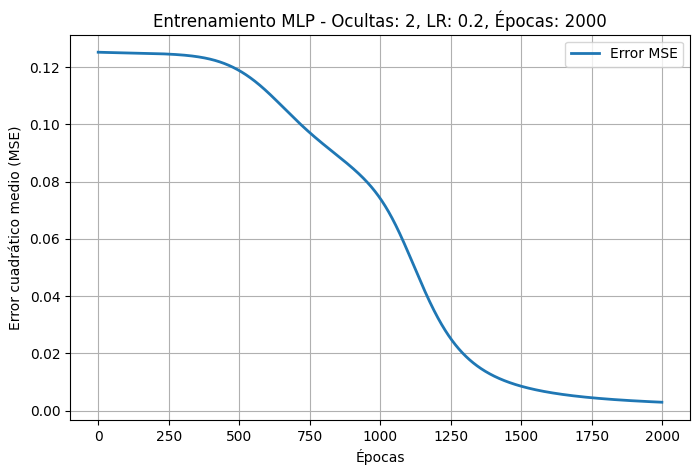


Entrenando con 3 neuronas ocultas...
Época 0, Error batch 1: 0.12970217819144253
Época 0, Error: 0.12970217819144253
Época 100, Error batch 1: 0.12500502759443158
Época 100, Error: 0.12500502759443158
Época 200, Error batch 1: 0.12459397638764086
Época 200, Error: 0.12459397638764086
Época 300, Error batch 1: 0.12387296139587196
Época 300, Error: 0.12387296139587196
Época 400, Error batch 1: 0.12201664564265353
Época 400, Error: 0.12201664564265353
Época 500, Error batch 1: 0.11707556036159837
Época 500, Error: 0.11707556036159837
Época 600, Error batch 1: 0.10721087098264849
Época 600, Error: 0.10721087098264849
Época 700, Error batch 1: 0.09556838705372214
Época 700, Error: 0.09556838705372214
Época 800, Error batch 1: 0.08509695713650613
Época 800, Error: 0.08509695713650613
Época 900, Error batch 1: 0.06437726895024896
Época 900, Error: 0.06437726895024896
Época 1000, Error batch 1: 0.033214509825975715
Época 1000, Error: 0.033214509825975715
Época 1100, Error batch 1: 0.017404188

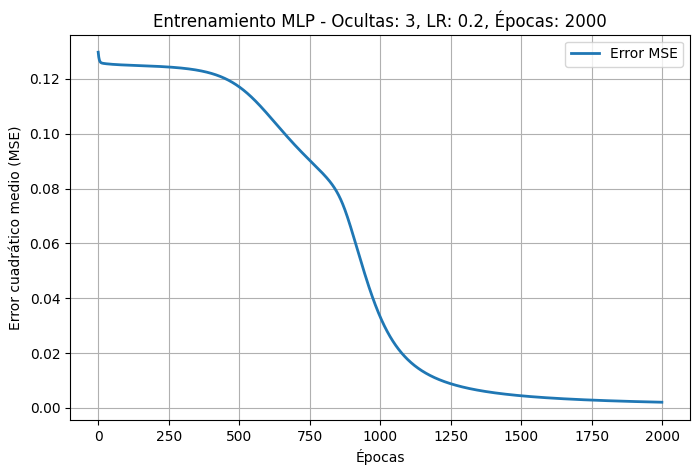


Entrenando con 5 neuronas ocultas...
Época 0, Error batch 1: 0.1262225322440075
Época 0, Error: 0.1262225322440075
Época 100, Error batch 1: 0.12484223065187901
Época 100, Error: 0.12484223065187901
Época 200, Error batch 1: 0.12452562403900963
Época 200, Error: 0.12452562403900963
Época 300, Error batch 1: 0.12350724627169776
Época 300, Error: 0.12350724627169776
Época 400, Error batch 1: 0.12008905292522042
Época 400, Error: 0.12008905292522042
Época 500, Error batch 1: 0.11102923967219192
Época 500, Error: 0.11102923967219192
Época 600, Error batch 1: 0.09390618939255455
Época 600, Error: 0.09390618939255455
Época 700, Error batch 1: 0.06971638066028063
Época 700, Error: 0.06971638066028063
Época 800, Error batch 1: 0.04332444477707968
Época 800, Error: 0.04332444477707968
Época 900, Error batch 1: 0.02496469321870451
Época 900, Error: 0.02496469321870451
Época 1000, Error batch 1: 0.015205533956537717
Época 1000, Error: 0.015205533956537717
Época 1100, Error batch 1: 0.01011668239

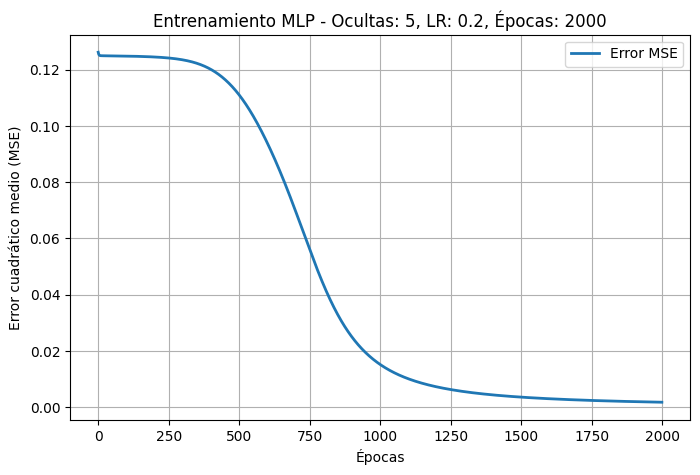


Entrenando con 8 neuronas ocultas...
Época 0, Error batch 1: 0.124925525592856
Época 0, Error: 0.124925525592856
Época 100, Error batch 1: 0.12367979014477128
Época 100, Error: 0.12367979014477128
Época 200, Error batch 1: 0.11934457412573755
Época 200, Error: 0.11934457412573755
Época 300, Error batch 1: 0.10679073191491759
Época 300, Error: 0.10679073191491759
Época 400, Error batch 1: 0.0773594831780226
Época 400, Error: 0.0773594831780226
Época 500, Error batch 1: 0.04016361858463791
Época 500, Error: 0.04016361858463791
Época 600, Error batch 1: 0.019951901796835994
Época 600, Error: 0.019951901796835994
Época 700, Error batch 1: 0.011624816736358345
Época 700, Error: 0.011624816736358345
Época 800, Error batch 1: 0.0077535285659371365
Época 800, Error: 0.0077535285659371365
Época 900, Error batch 1: 0.005659263372921965
Época 900, Error: 0.005659263372921965
Época 1000, Error batch 1: 0.00438852940615923
Época 1000, Error: 0.00438852940615923
Época 1100, Error batch 1: 0.0035506

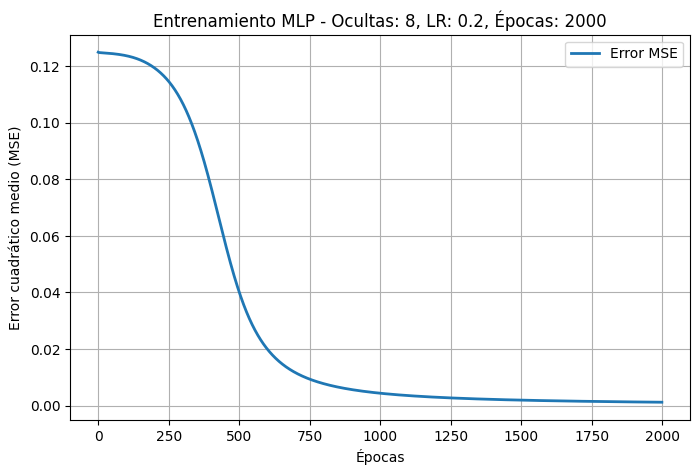


Entrenando con 12 neuronas ocultas...
Época 0, Error batch 1: 0.12749138189838244
Época 0, Error: 0.12749138189838244
Época 100, Error batch 1: 0.12316584086725271
Época 100, Error: 0.12316584086725271
Época 200, Error batch 1: 0.11885516818176377
Época 200, Error: 0.11885516818176377
Época 300, Error batch 1: 0.10865163452499123
Época 300, Error: 0.10865163452499123
Época 400, Error batch 1: 0.08998072000749315
Época 400, Error: 0.08998072000749315
Época 500, Error batch 1: 0.06611518377345563
Época 500, Error: 0.06611518377345563
Época 600, Error batch 1: 0.044310180876596425
Época 600, Error: 0.044310180876596425
Época 700, Error batch 1: 0.028847822219605083
Época 700, Error: 0.028847822219605083
Época 800, Error batch 1: 0.01919313367167247
Época 800, Error: 0.01919313367167247
Época 900, Error batch 1: 0.01333011665687158
Época 900, Error: 0.01333011665687158
Época 1000, Error batch 1: 0.009695025300809285
Época 1000, Error: 0.009695025300809285
Época 1100, Error batch 1: 0.0073

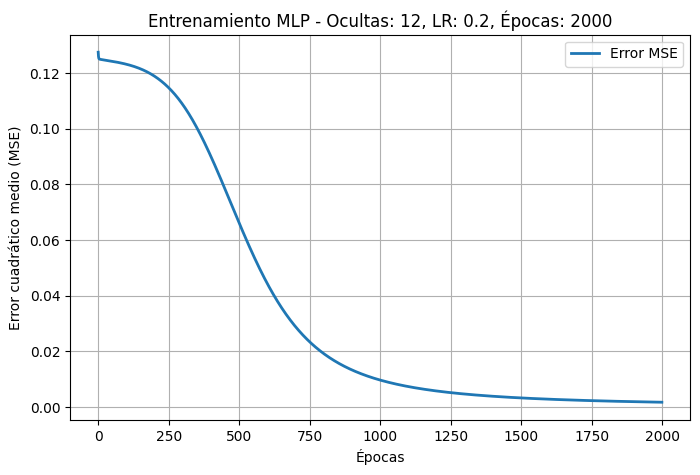

In [27]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

configuraciones = [2, 3, 5, 8, 12]  # número de neuronas ocultas

for n_ocultas in configuraciones:
    print(f"\nEntrenando con {n_ocultas} neuronas ocultas...")
    mlp = MLP_TODO(num_entradas=2, num_neuronas_ocultas=n_ocultas,
                   num_salidas=1, epochs=2000, learning_rate=0.2)
    mlp.train(X, y)
    mlp.plot_error()


Época 0, Error batch 1: 0.12512389491474757
Época 0, Error: 0.12512389491474757, Accuracy: 50.00%
Época 100, Error batch 1: 0.12485120258207268
Época 100, Error: 0.12485120258207268, Accuracy: 50.00%
Época 200, Error batch 1: 0.12446427947201982
Época 200, Error: 0.12446427947201982, Accuracy: 50.00%
Época 300, Error batch 1: 0.12317475435031532
Época 300, Error: 0.12317475435031532, Accuracy: 75.00%
Época 400, Error batch 1: 0.11874050175439138
Época 400, Error: 0.11874050175439138, Accuracy: 75.00%
Época 500, Error batch 1: 0.10896020125407205
Época 500, Error: 0.10896020125407205, Accuracy: 75.00%
Época 600, Error batch 1: 0.0971120980126288
Época 600, Error: 0.0971120980126288, Accuracy: 75.00%
Época 700, Error batch 1: 0.08699246550639925
Época 700, Error: 0.08699246550639925, Accuracy: 75.00%
Época 800, Error batch 1: 0.07421475777474326
Época 800, Error: 0.07421475777474326, Accuracy: 75.00%
Época 900, Error batch 1: 0.04950273199740135
Época 900, Error: 0.04950273199740135, Acc

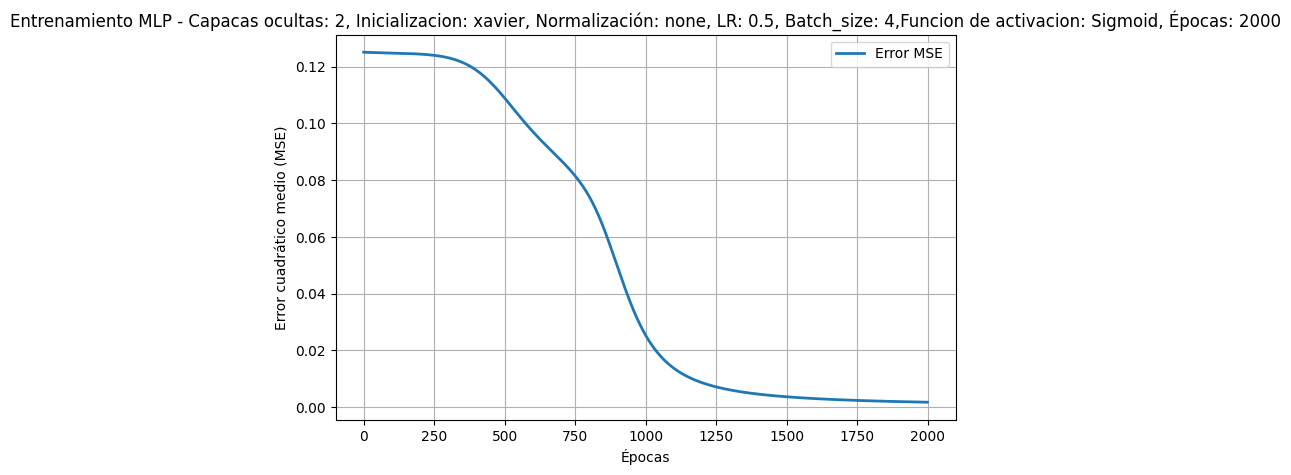


🔍 Evaluación del modelo (esperada | predicha):
01: 0 | 0
02: 1 | 1
03: 1 | 1
04: 0 | 0

✅ Precisión del modelo: 100.00%


np.float64(1.0)

In [26]:
#Ejemplo del uso para el entrenamiento

# Definimos los datos de entrada para XOR
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

# Salidas esperadas para XOR
y = np.array([[0], 
              [1], 
              [1], 
              [0]])

entradas = 2
neuronas_ocultas = 2
salidas = 1
batch_size = 4 # Batch de 2 ejemplos # X.shape[0] # Batch de todos los ejemplos
# batch_size = X.shape[0] # Batch de todos los ejemplos
learning_rate = 0.5
epochs = 2000
clasificador = MLP_TODO(entradas, neuronas_ocultas, salidas, epochs=epochs, batch_size=batch_size,normalizacion="none",inicializacion="xavier",learning_rate=learning_rate)
clasificador.train(X,y)
clasificador.plot_error()
#clasificador.plot_accuracy()
#clasificador.plot_metrics()
#y_pred = clasificador.predict(X)
clasificador.evaluar(X,y)
#print("Esperada:\n", y)
#print("Predicha:\n", y_pred)

In [20]:
X



array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

Conjunto de datos cargado desde: ./iris_train.csv
   → Ejemplos: 80, Características: 4
   → Clases únicas en y: [0 1]
Conjunto de datos cargado desde: ./iris_test.csv
   → Ejemplos: 20, Características: 4
   → Clases únicas en y: [0 1]

🔹 Entrenando con -> Neuronas=2, Init=normal, Norm=none, LR=0.01, Batch=8
Época 0, Error batch 1: 0.12498865603706577
Época 0, Error batch 2: 0.12498321176984509
Época 0, Error batch 3: 0.12513549305019006
Época 0, Error batch 4: 0.12498797896139516
Época 0, Error batch 5: 0.1250669860192318
Época 0, Error batch 6: 0.1249865634316841
Época 0, Error batch 7: 0.12490892266212121
Época 0, Error batch 8: 0.12529151575081995
Época 0, Error batch 9: 0.12496960260545395
Época 0, Error batch 10: 0.12497294268909832
Época 0, Error: 0.12502918729769055, Accuracy: 78.75%

🔹 Entrenando con -> Neuronas=2, Init=normal, Norm=none, LR=0.01, Batch=16
Época 0, Error batch 1: 0.12498593849263438
Época 0, Error batch 2: 0.12506172359448378
Época 0, Error batch 3: 0.1250669

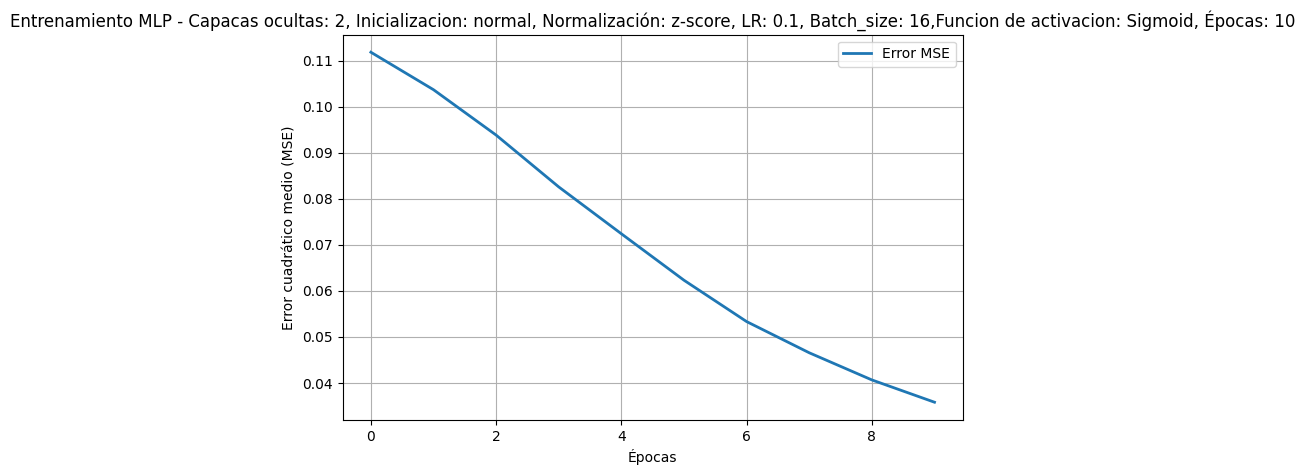

Modelo TOP 19: {'Neuronas': 2, 'Inicialización': 'normal', 'Normalización': 'z-score', 'Learning rate': 0.1, 'Batch size': 32, 'Accuracy': 1.0, 'Error final': 0.0, 'Tiempo (s)': 0.0}
Época 0, Error batch 1: 0.11039389358651451
Época 0, Error batch 2: 0.12093565158312335
Época 0, Error batch 3: 0.10776475950953125
Época 0, Error: 0.11303143489305638, Accuracy: 80.00%

🔍 Evaluación del modelo (esperada | predicha):
01: 1 | 1
02: 1 | 1
03: 1 | 1
04: 1 | 1
05: 0 | 0
06: 0 | 0
07: 0 | 0
08: 1 | 1
09: 0 | 0
10: 0 | 0
11: 0 | 0
12: 1 | 1
13: 0 | 0
14: 0 | 0
15: 0 | 0
16: 1 | 1
17: 1 | 1
18: 0 | 0
19: 1 | 1
20: 1 | 1

✅ Precisión del modelo: 100.00%


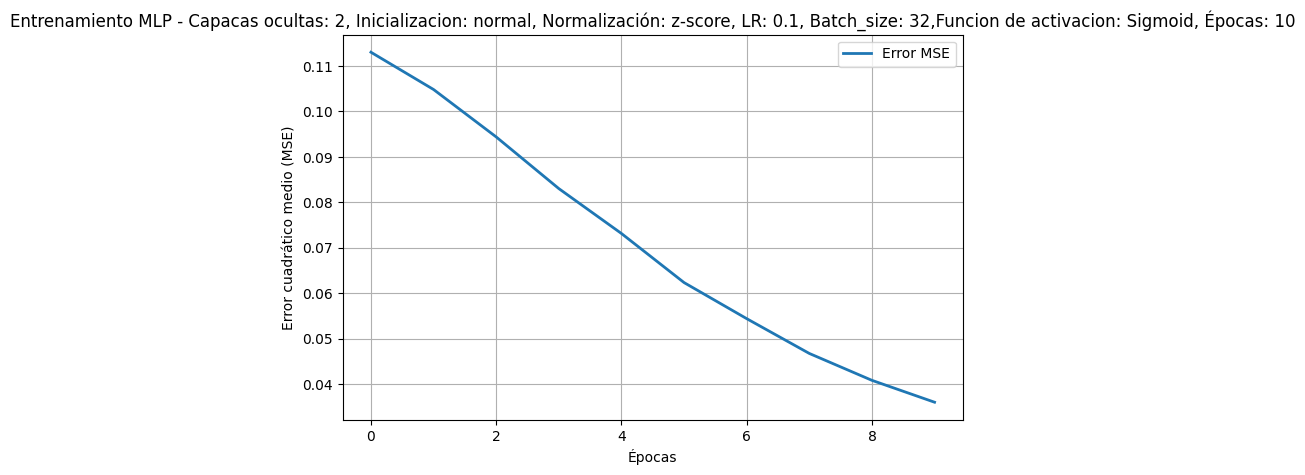

Modelo TOP 20: {'Neuronas': 2, 'Inicialización': 'normal', 'Normalización': 'z-score', 'Learning rate': 0.1, 'Batch size': 64, 'Accuracy': 1.0, 'Error final': 0.0, 'Tiempo (s)': 0.0}
Época 0, Error batch 1: 0.11440639425686758
Época 0, Error batch 2: 0.11076823162039609
Época 0, Error: 0.11258731293863183, Accuracy: 78.75%

🔍 Evaluación del modelo (esperada | predicha):
01: 1 | 1
02: 1 | 1
03: 1 | 1
04: 1 | 1
05: 0 | 0
06: 0 | 0
07: 0 | 0
08: 1 | 1
09: 0 | 0
10: 0 | 0
11: 0 | 0
12: 1 | 1
13: 0 | 0
14: 0 | 0
15: 0 | 0
16: 1 | 1
17: 1 | 1
18: 0 | 0
19: 1 | 1
20: 1 | 1

✅ Precisión del modelo: 100.00%


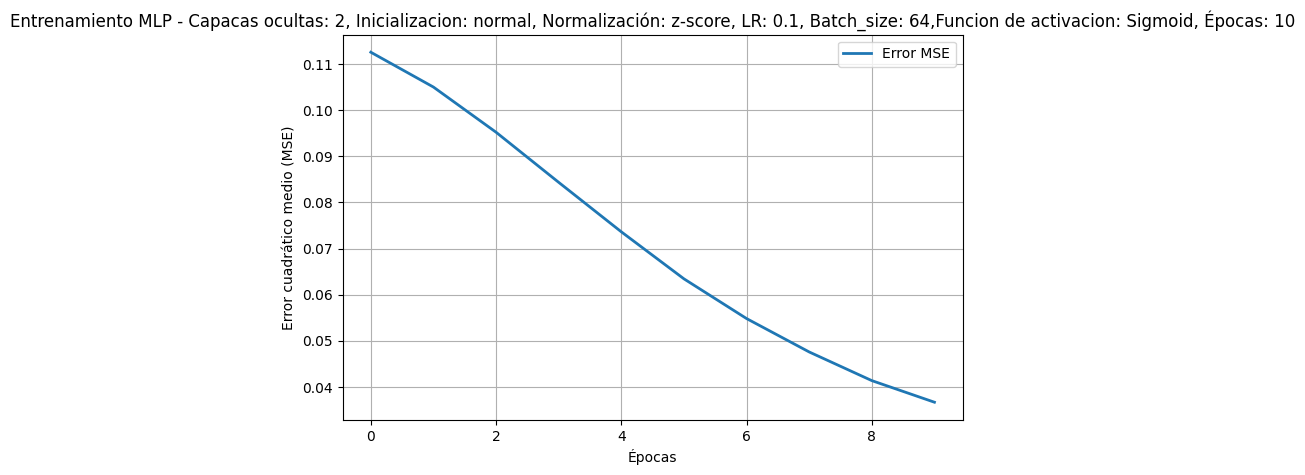

In [36]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

# ===============================================
# Definir hiperparámetros a probar
# ===============================================
neuronas_ocultas = [2, 4, 8, 16, 32, 128]
inicializaciones = ["normal", "xavier"]
normalizaciones = ["none", "z-score"]
learning_rates = [0.01, 0.1, 0.5]
batch_sizes = [8, 16, 32, 64]
epochs = 10  # puedes usar menos si el entrenamiento tarda mucho

# ===============================================
# Cargar datasets
# ===============================================
X_train, y_train = cargar_dataset("./iris_train.csv")
X_test, y_test = cargar_dataset("./iris_test.csv")

# ===============================================
# Lista para almacenar resultados
# ===============================================
resultados = []

# ===============================================
# Entrenamiento con todas las combinaciones
# ===============================================
for neuronas in neuronas_ocultas:
    for init in inicializaciones:
        for norm in normalizaciones:
            for lr in learning_rates:
                for batch in batch_sizes:

                    print(f"\n🔹 Entrenando con -> Neuronas={neuronas}, Init={init}, Norm={norm}, LR={lr}, Batch={batch}")

                    # Crear el modelo MLP
                    modelo = MLP_TODO(
                        num_entradas=X_train.shape[1],
                        num_neuronas_ocultas=neuronas,
                        num_salidas=1,
                        epochs=epochs,
                        batch_size=batch,
                        learning_rate=lr,
                        normalizacion=norm,
                        inicializacion=init
                    )

                    # Medir tiempo de entrenamiento
                    inicio = time()
                    modelo.train(X_train, y_train)
                    duracion = round(time() - inicio, 2)

                    # Predicciones y métricas
                    y_pred = modelo.predict(X_test)
                    acc = np.mean(y_pred == y_test)  # Accuracy
                    error_final = modelo.loss_function_MSE(y_pred, y_test)  # Error final

                    # Guardar resultados
                    resultados.append({
                        "Neuronas": neuronas,
                        "Inicialización": init,
                        "Normalización": norm,
                        "Learning rate": lr,
                        "Batch size": batch,
                        "Accuracy": acc,
                        "Error final": error_final,   
                        "Tiempo (s)": duracion
                    })

# ===============================================
# Crear DataFrame con todos los resultados
# ===============================================
df_resultados = pd.DataFrame(resultados)

# Ordenar primero por Accuracy descendente y luego por Error final ascendente
df_resultados = df_resultados.sort_values(
    by=["Accuracy", "Error final", "Tiempo (s)"],  # columnas a ordenar
    ascending=[False, True, True]                  # False=descendente, True=ascendente
)

# Guardar todos los resultados
df_resultados.to_csv("resultados_mlp_todos.csv", index=False)
print("\nResultados guardados en 'resultados_mlp_todos.csv'")

# ===============================================
# Mostrar y guardar Top 10
# ===============================================
top10 = df_resultados.head(10)
print("\nTop 10 mejores configuraciones:")
print(top10)

top10.to_csv("resultados_mlp_top10.csv", index=False)
print("Top 10 guardado en 'resultados_mlp_top10.csv'")

# ===============================================
# Reentrenar las 3 mejores configuraciones
# ===============================================
print("\nReentrenando las 3 mejores configuraciones para graficar...\n")

top3 = top10.head(3)

for i, row in top3.iterrows():
    print(f"Modelo TOP {i+1}: {row.to_dict()}")

    modelo = MLP_TODO(
        num_entradas=X_train.shape[1],
        num_neuronas_ocultas=row["Neuronas"],
        num_salidas=1,
        epochs=epochs,
        batch_size=row["Batch size"],
        learning_rate=row["Learning rate"],
        normalizacion=row["Normalización"],
        inicializacion=row["Inicialización"]
    )

    modelo.train(X_train, y_train)
    modelo.evaluar(X_test, y_test)
    
    # Graficar evolución del error
    modelo.plot_error()



In [23]:
from tabulate import tabulate

# Seleccionamos las columnas más importantes para el reporte
columnas_reporte = ["Neuronas", "Normalización", "Learning rate", 
                    "Batch size", "Accuracy", "Error final", "Tiempo (s)"]

# Ordenamos por Accuracy descendente y luego Error ascendente
df_comparativa = df_resultados.sort_values(
    by=["Accuracy", "Error final"],
    ascending=[False, True]
)[columnas_reporte]

# Creamos la tabla para las 10 mejores configuraciones
top10_tabla = df_comparativa.head(10)

# Resaltar Normalización, Learning rate y Neuronas con símbolos o mayúsculas
def resaltar(row):
    return [
        f"**{row['Neuronas']}**",             # Neuronas en negrita
        f"**{row['Normalización']}**",        # Normalización en negrita
        f"**{row['Learning rate']}**",        # Learning rate en negrita
        row["Batch size"],
        f"{row['Accuracy']*100:.2f}%",
        f"{row['Error final']:.5f}",
        f"{row['Tiempo (s)']:.2f}"
    ]

tabla_final = [resaltar(row) for _, row in top10_tabla.iterrows()]

# Definimos encabezados
headers = ["Neuronas", "Normalización", "LR", "Batch", "Accuracy", "Error final", "Tiempo (s)"]

# Imprimir tabla
print("\nTabla comparativa de las 10 mejores configuraciones:")
print(tabulate(tabla_final, headers=headers, tablefmt="grid"))



Tabla comparativa de las 10 mejores configuraciones:
+------------+-----------------+----------+---------+------------+---------------+--------------+
| Neuronas   | Normalización   | LR       |   Batch | Accuracy   |   Error final |   Tiempo (s) |
+============+=================+==========+=========+============+===============+==============+
| **2**      | **z-score**     | **0.5**  |      64 | 100.00%    |             0 |         0.43 |
+------------+-----------------+----------+---------+------------+---------------+--------------+
| **2**      | **none**        | **0.5**  |      64 | 100.00%    |             0 |         0.43 |
+------------+-----------------+----------+---------+------------+---------------+--------------+
| **2**      | **none**        | **0.5**  |      64 | 100.00%    |             0 |         0.44 |
+------------+-----------------+----------+---------+------------+---------------+--------------+
| **2**      | **none**        | **0.1**  |      64 | 100.00%   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from time import time

# ====================================================
# Funciones para activación y  su derivada
# ====================================================
def cargar_dataset(ruta):
    """
    Carga un conjunto de datos desde un archivo CSV y separa las características (X)
    de la columna objetivo (y), que corresponde a la última columna del archivo.

    Parámetros:
    ------------
    ruta : str
        Ruta del archivo CSV (por ejemplo: './iris_train.csv')

    Retorna:
    ---------
    X : np.ndarray
        Matriz con las características o variables de entrada.
    y : np.ndarray
        Vector columna con la clase o variable objetivo.
    """
    # Cargar el archivo CSV con pandas
    datos = pd.read_csv(ruta)

    # Separar las características (todas menos la última columna)
    X = datos.iloc[:, :-1].values  

    # Separar la columna objetivo (última columna)
    y = datos.iloc[:, -1].values  

    # Asegurar que y sea un vector columna (n x 1)
    y = y.reshape(-1, 1)

    # Mostrar información del dataset cargado
    print(f"Conjunto de datos cargado desde: {ruta}")
    print(f"   → Ejemplos: {X.shape[0]}, Características: {X.shape[1]}")
    print(f"   → Clases únicas en y: {np.unique(y).ravel()}")

    return X, y


# Función de activación sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivada de la sigmoide
def sigmoid_derivative(x):
    # return sigmoid(x) * (1 - sigmoid(x))
    return x * (1 - x)

# ====================================================
# Funciones para manejo de la semilla
# ====================================================

# Establece la semilla para la generación de números aleatorios
def seed(random_state=33):
    np.random.seed(random_state)
    random.seed(random_state)

# ====================================================
# Funciones para inicialización y normalización
# ====================================================

# Inicialización Xavier
def xavier_initialization(input_size, output_size): 
    return np.random.randn(input_size, output_size) * np.sqrt(1 / input_size)
# Inicialización normal
def normal_initialization(input_size, output_size):
    return np.random.randn(input_size, output_size)
# Normalización Z-score
def zscore_normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_norm = (X - mean) / std
    return X_norm

#Función para crear minibatches
def create_minibatches(X, y, batch_size):
    """
    Genera los lotes de datos (batchs) de acuerdo al parámetro batch_size de forma aleatoria para el procesamiento. 
    """
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)  # Mezcla los índices aleatoriamente
    X_shuffled, y_shuffled = X[indices], y[indices]  # Reordena X e y según los índices aleatorios
    
    # Divide los datos en minibatches
    for X_batch, y_batch in zip(np.array_split(X_shuffled, np.ceil(n_samples / batch_size)), 
                                np.array_split(y_shuffled, np.ceil(n_samples / batch_size))):
        yield X_batch, y_batch

    
class MLP_TODO:
    def __init__(self, num_entradas, num_neuronas_ocultas, num_salidas, epochs, batch_size=128, learning_rate=0.2, normalizacion="none",inicializacion="xavier",random_state=42):

        # ====================================================
        # Inicialización general del modelo
        # ====================================================

        # 🔹 NUEVO: Usar el parámetro random_state recibido para controlar la semilla
        seed(random_state)
        self.random_state = random_state  # 🔹 NUEVO: guardar la semilla para usarla también en create_minibatches

        # Definir la tasa de aprendizaje
        self.learning_rate = learning_rate
        # Definir el número de épocas
        self.epochs = epochs
        # Definir el tamaño del batch de procesamiento
        self.batch_size = batch_size
        # Definir el tipo de normalización
        self.normalizacion = normalizacion
        # Definir el tipo de inicialización
        self.inicializacion = inicializacion
        # definir las 
        self.num_neuronas_ocultas = num_neuronas_ocultas

        # Inicialización de pesos y bias
        self.W1 = self.inicializar_pesos(num_entradas, self.num_neuronas_ocultas) # Pesos entre capa de entrada y capa oculta
        self.b1 = np.zeros((1, self.num_neuronas_ocultas))   # Bias de la capa oculta
        self.W2 = self.inicializar_pesos(self.num_neuronas_ocultas,num_salidas)  # Pesos entre capa oculta y capa de salida
        self.b2 = np.zeros((1, num_salidas)) # Bias de la capa de salida

        # Historial de errores
        self.errores_history = []
        # Historial de accuracy
        self.accuracy_history = []

    # ====================================================
    # Funciones para forward, backward, update, predict y train
    # ====================================================

    def forward(self, X):
        #implementar el forward pass
        #----------------------------------------------
        # 1. Propagación hacia adelante (Forward pass)
        #----------------------------------------------
        # Calcular la suma ponderada Z (z_c1) para la capa oculta 
        self.X = X
        self.z_c1 = X@self.W1 + self.b1
        #Calcular la activación de la capa oculta usando la función sigmoide
        self.a_c1 = sigmoid(self.z_c1)  # Activación capa oculta
        #Calcular la suma ponderada Z (z_c2)  para la capa de salida 
        self.z_c2  = self.a_c1 @ self.W2 + self.b2
        #Calcular la activación de la capa de salida usando la función sigmoide
        y_pred = sigmoid(self.z_c2)  # Activación capa salida
        return y_pred
    

    def loss_function_MSE(self, y_pred, y):
        #----------------------------------------------
        # 2. Cálculo del error con MSE
        #----------------------------------------------
        #Calcular el error cuadrático medio (MSE)
        self.y_pred = y_pred
        self.y = y
        error = 0.5 * np.mean((y_pred - y) ** 2)
        return error
    

    def backward(self):
        #implementar el backward pass
        # calcular los gradientes para la arquitectura de la figura anterior
        #----------------------------------------------
        # 3. Propagación hacia atrás (Backward pass)
        #----------------------------------------------
        
        #----------------------------------------------
        # Gradiente de la salida
        #----------------------------------------------
        #Calcular la derivada del error con respecto a la salida y
        dE_dy_pred = (self.y_pred - self.y)  # Derivada del error respecto a la predicción con  N ejemplos
        #Calcular la derivada de la activación de la salida con respecto a z_c2 
        d_y_pred_d_zc2 = sigmoid_derivative(self.y_pred)
        #Calcular delta de la capa de salida
        delta_c2 = dE_dy_pred * d_y_pred_d_zc2  # (N, 1)

        #----------------------------------------------
        # Gradiente en la capa oculta
        #----------------------------------------------
        # calcular la derivada de las suma ponderada respecto a las activaciones de la capa 1
        d_zc2_d_a_c1 = self.W2  
        #Propagar el error hacia la capa oculta, calcular deltas de la capa 1
        delta_c1 = delta_c2 @ d_zc2_d_a_c1.T * sigmoid_derivative(self.a_c1)  

        #calcula el gradiente de la función de error respecto a los pesos de la capa 2
        self.dE_dW2 = self.a_c1.T @ delta_c2
        self.dE_db2 = np.sum(delta_c2, axis=0, keepdims=True)
        self.dE_dW1 = self.X.T @ delta_c1 
        self.dE_db1 = np.sum(delta_c1, axis=0, keepdims=True) 


    def update(self):  # Ejecución de la actualización de paramámetros
        #implementar la actualización de los pesos y el bias
        #----------------------------------------------
        # Actualización de pesos de la capa de salida
        #---------------------------------------------- 
        #Actualizar los pesos y bias de la capa de salida
        self.W2 = self.W2 - self.dE_dW2 * self.learning_rate
        self.b2 = self.b2 - self.dE_db2 * self.learning_rate
        #----------------------------------------------
        # Actuailzación de pesos de la capa oculta
        #----------------------------------------------
        #calcula el gradiente de la función de error respecto a los pesos de la capa 1
        self.W1 = self.W1 - self.dE_dW1 * self.learning_rate
        self.b1 = self.b1 - self.dE_db1 * self.learning_rate

    def predict(self, X):  # Predecir la categoría para datos nuevos
        # TODO: implementar la predicción 
        y_pred = self.forward(X)
        # Obtener la clase para el clasificador binario
        y_pred = np.where(y_pred >= 0.5, 1, 0)
        return y_pred

    def train(self, X, Y):
        #implementar el entrenamiento de la red
            # 🔹 Normalizar los datos según el tipo configurado
        X = self.normalize(X)
        for epoch in range(self.epochs):
            num_batch = 0
            epoch_error  = 0
            for X_batch, y_batch in create_minibatches(X, Y, self.batch_size):
                y_pred = self.forward(X_batch)
                error = self.loss_function_MSE(y_pred, y_batch)
                epoch_error += error    
                self.backward() # cálculo de los gradientes
                self.update() # actualización de los pesos y bias
                num_batch += 1
                # Imprimir el error cada N épocas
                if epoch % 100 == 0:
                    print(f"Época {epoch}, Error batch {num_batch}: {error}")
            # Guardar el error promedio de la época
            self.errores_history.append(epoch_error/num_batch)
            #Calcular Accuracy en todo el dataset
            acc_epoch = self.accuracy(X, Y)
            self.accuracy_history.append(acc_epoch)
            # Imprimir el error y accuracy cada N épocas
            if epoch % 100 == 0:
                    print(f"Época {epoch}, Error: {epoch_error/num_batch}%")

    def evaluar(self, X, y):
        """
        Evalúa el desempeño del modelo en un conjunto de prueba.
        Muestra todas las predicciones junto con las salidas esperadas en columnas paralelas.
        Calcula la precisión total.
        """
        # Normalizar los datos de entrada con la misma técnica usada en entrenamiento
        X = self.normalize(X)

        # Obtener las predicciones
        y_pred = self.predict(X)

        # Combinar esperadas y predicciones en columnas paralelas
        resultados = np.column_stack((y, y_pred))
        
        # Mostrar resultados
        print("\n🔍 Evaluación del modelo (esperada | predicha):")
        for idx, (esperada, predicha) in enumerate(resultados):
            print(f"{idx+1:02d}: {esperada} | {predicha}")

        # Calcular precisión global
        accuracy = np.mean(y_pred == y)
        print(f"\n✅ Precisión del modelo: {accuracy * 100:.2f}%")

        return accuracy


    
    # ====================================================
    # Funciones para inicialización, normalización y accuracy
    # ====================================================
    # Normalización de los datos
    def normalize(self, X):
        if self.normalizacion == "z-score":
            return zscore_normalization(X)  # 🔹 Llamada a la función existente
        else:  # sin normalizar
            return X
        
    # Inicialización de los pesos  
    def inicializar_pesos(self, tamaño_entrada, tamaño_salida):
        if self.inicializacion == "xavier":
            return xavier_initialization(tamaño_entrada, tamaño_salida)
        elif self.inicializacion == "normal":
            return normal_initialization(tamaño_entrada, tamaño_salida)
        else:
            raise ValueError("Tipo de inicialización no soportado")
    # Cálculo de accuracy    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        acc = np.mean(y_pred == y)  # compara predicciones con valores reales
        return acc
    
    # ====================================================
    # Funciones para graficar Error, Acurery y ambas
    # ====================================================
    
    # Gráfica del error despues del entrenamiento
    def plot_error(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.errores_history, label="Error MSE", linewidth=2)
        plt.xlabel("Épocas")
        plt.ylabel("Error cuadrático medio (MSE)")
        #Título dinámico con configuración
        plt.title(f"Entrenamiento MLP - Capacas ocultas: {self.num_neuronas_ocultas}, Inicializacion: {self.inicializacion}, Normalización: {self.normalizacion}, "
                f"LR: {self.learning_rate}, Batch_size: {self.batch_size},Funcion de activacion: Sigmoid, Épocas: {self.epochs}")
        plt.legend()
        plt.grid(True)
        plt.show()




   
# ===============================================
# Definir hiperparámetros a probar
# ===============================================
neuronas_ocultas = [2, 4, 8, 16, 32, 128]
inicializaciones = ["normal", "xavier"]
normalizaciones = ["none", "z-score"]
learning_rates = [0.01, 0.1, 0.5]
batch_sizes = [8, 16, 32, 64]
epochs = 2000  # puedes usar menos si el entrenamiento tarda mucho

# ===============================================
# Cargar datasets
# ===============================================
X_train, y_train = cargar_dataset("Practica_1/iris_train.csv")
X_test, y_test = cargar_dataset("Practica_1/iris_test.csv")

# ===============================================
# Lista para almacenar resultados
# ===============================================
resultados = []

# ===============================================
# Entrenamiento con todas las combinaciones
# ===============================================
for neuronas in neuronas_ocultas:
    for init in inicializaciones:
        for norm in normalizaciones:
            for lr in learning_rates:
                for batch in batch_sizes:

                    print(f"\n🔹 Entrenando con -> Neuronas={neuronas}, Init={init}, Norm={norm}, LR={lr}, Batch={batch}")

                    # Crear el modelo MLP
                    modelo = MLP_TODO(
                        num_entradas=X_train.shape[1],
                        num_neuronas_ocultas=neuronas,
                        num_salidas=1,
                        epochs=epochs,
                        batch_size=batch,
                        learning_rate=lr,
                        normalizacion=norm,
                        inicializacion=init
                    )

                    # Medir tiempo de entrenamiento
                    inicio = time()
                    modelo.train(X_train, y_train)
                    duracion = round(time() - inicio, 2)

                    # Predicciones y métricas
                    y_pred = modelo.predict(X_test)
                    acc = np.mean(y_pred == y_test)  # Accuracy
                    error_final = modelo.loss_function_MSE(y_pred, y_test)  # Error final

                    # Guardar resultados
                    resultados.append({
                        "Neuronas": neuronas,
                        "Inicialización": init,
                        "Normalización": norm,
                        "Learning rate": lr,
                        "Batch size": batch,
                        "Accuracy": acc,
                        "Error final": error_final,   
                        "Tiempo (s)": duracion
                    })

# ===============================================
# Crear DataFrame con todos los resultados
# ===============================================
df_resultados = pd.DataFrame(resultados)

# Ordenar primero por Accuracy descendente y luego por Error final ascendente
df_resultados = df_resultados.sort_values(
    by=["Accuracy", "Error final", "Tiempo (s)"],  # columnas a ordenar
    ascending=[False, True, True]                  # False=descendente, True=ascendente
)

# Guardar todos los resultados
df_resultados.to_csv("resultados_mlp_todos.csv", index=False)
print("\nResultados guardados en 'resultados_mlp_todos.csv'")

# ===============================================
# Mostrar y guardar Top 10
# ===============================================
top10 = df_resultados.head(10)
print("\nTop 10 mejores configuraciones:")
print(top10)

top10.to_csv("resultados_mlp_top10.csv", index=False)
print("Top 10 guardado en 'resultados_mlp_top10.csv'")

# ===============================================
# Reentrenar las 3 mejores configuraciones
# ===============================================
print("\nReentrenando las 3 mejores configuraciones para graficar...\n")

top3 = top10.head(3)

for i, row in top3.iterrows():
    print(f"Modelo TOP {i+1}: {row.to_dict()}")

    modelo = MLP_TODO(
        num_entradas=X_train.shape[1],
        num_neuronas_ocultas=row["Neuronas"],
        num_salidas=1,
        epochs=epochs,
        batch_size=row["Batch size"],
        learning_rate=row["Learning rate"],
        normalizacion=row["Normalización"],
        inicializacion=row["Inicialización"]
    )

    modelo.train(X_train, y_train)
    # Graficar evolución del error
    modelo.plot_error()
    modelo.evaluar(X_test, y_test)
  
    
